I have used the following methods.

* Converting all images .jpg to .png
* A custom CNN model 
* Custom convolution block
* EarlyStopping and ReduceLROnPlateau callbacks


## Model

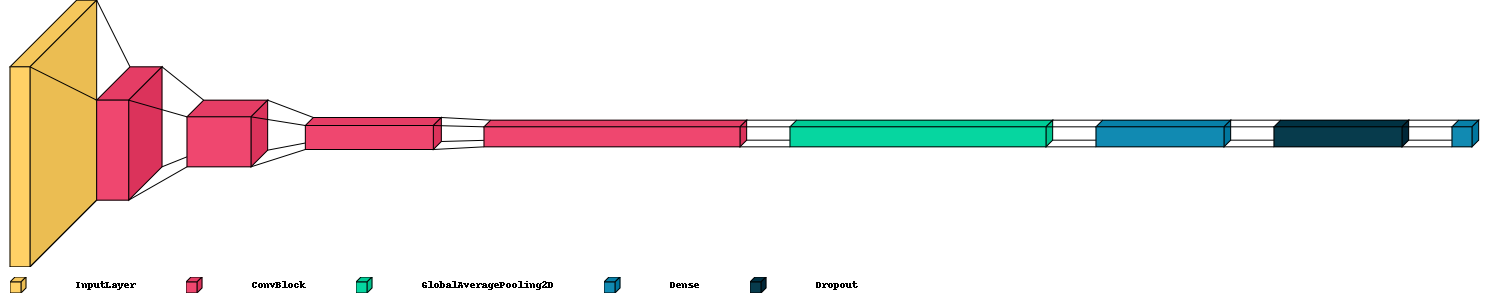


## Example Predictions

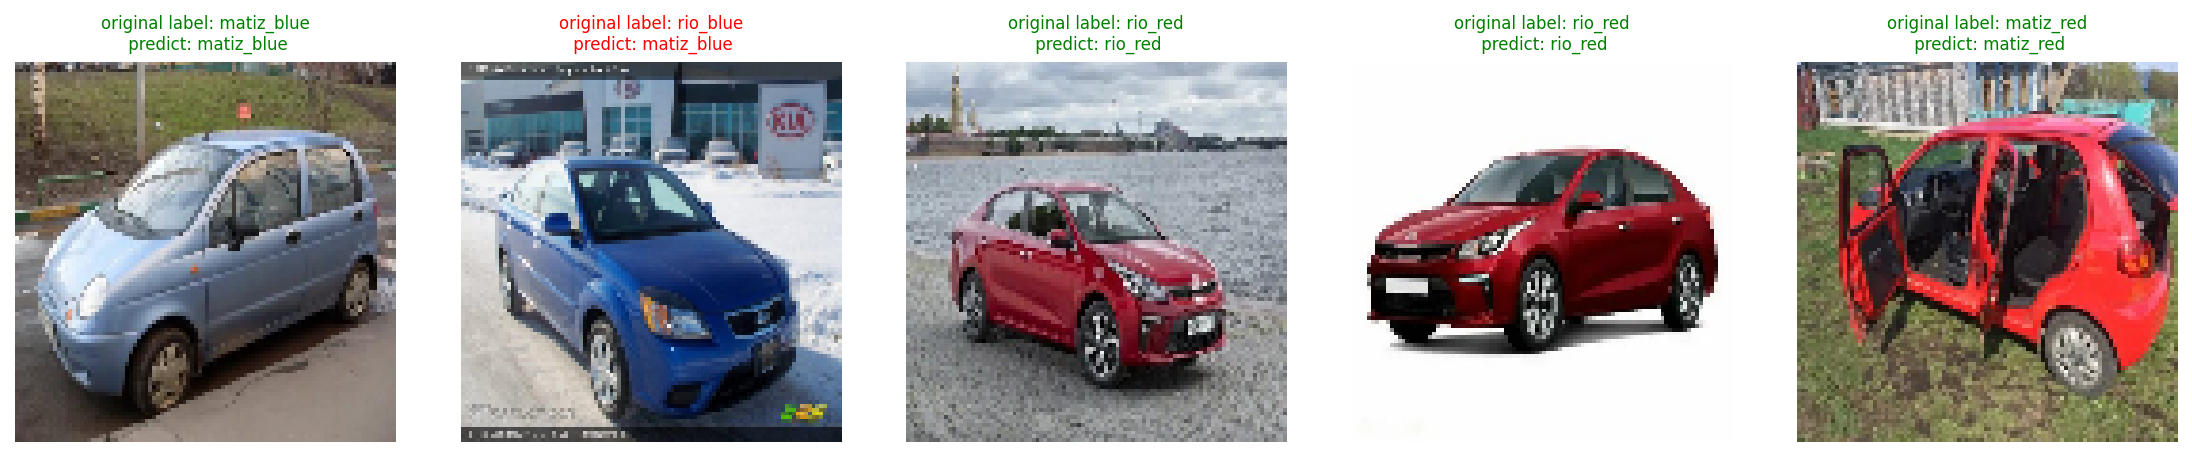


In [ ]:
from IPython.display import clear_output
!pip install visualkeras
clear_output()

In [ ]:
# Importing dependencies

import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2
import visualkeras

import catboost
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow.keras.layers import Layer,Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Model

SEED = 50
BATCH_SIZE = 32

# <span style="color:#e74c3c;"> Preprocessing </span>


In [ ]:
# Creating new folders

os.mkdir(os.path.join('/kaggle/working/',  'matiz_black_png'))
os.mkdir(os.path.join('/kaggle/working/',  'matiz_blue_png'))
os.mkdir(os.path.join('/kaggle/working/',  'matiz_red_png'))

os.mkdir(os.path.join('/kaggle/working/',  'rio_black_png'))
os.mkdir(os.path.join('/kaggle/working/',  'rio_blue_png'))
os.mkdir(os.path.join('/kaggle/working/',  'rio_red_png'))

os.mkdir(os.path.join('/kaggle/working/',  'tiggo_black_png'))
os.mkdir(os.path.join('/kaggle/working/',  'tiggo_blue_png'))
os.mkdir(os.path.join('/kaggle/working/',  'tiggo_red_png'))

In [ ]:
# Converting .jpg images to .png images

def new_images_path(main_path, target_path):
    for i in os.listdir(main_path):
        img = cv2.imread((os.path.join(main_path,i)))
        cv2.imwrite(os.path.join(target_path, i[:-3] + 'png'), img)
    

In [ ]:
new_images_path('/kaggle/input/multilabel-small-car-and-color-dataset/matiz black', '/kaggle/working/matiz_black_png')
new_images_path('/kaggle/input/multilabel-small-car-and-color-dataset/matiz blue', '/kaggle/working/matiz_blue_png')
new_images_path('/kaggle/input/multilabel-small-car-and-color-dataset/matiz red', '/kaggle/working/matiz_red_png')

new_images_path('/kaggle/input/multilabel-small-car-and-color-dataset/rio black', '/kaggle/working/rio_black_png')
new_images_path('/kaggle/input/multilabel-small-car-and-color-dataset/rio blue', '/kaggle/working/rio_blue_png')
new_images_path('/kaggle/input/multilabel-small-car-and-color-dataset/rio red', '/kaggle/working/rio_red_png')

new_images_path('/kaggle/input/multilabel-small-car-and-color-dataset/tiggo black', '/kaggle/working/tiggo_black_png')
new_images_path('/kaggle/input/multilabel-small-car-and-color-dataset/tiggo blue', '/kaggle/working/tiggo_blue_png')
new_images_path('/kaggle/input/multilabel-small-car-and-color-dataset/tiggo red', '/kaggle/working/tiggo_red_png')

# <span style="color:#e74c3c;"> Creating </span> Datasets


In [ ]:
# Creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = os.listdir(path)
    for i in tqdm(images, desc = 'images' ):
        full_path.append(os.path.join(path, i))
        
    return full_path

matiz_black_data = create_images_list('/kaggle/working/matiz_black_png')
matiz_blue_data = create_images_list('/kaggle/working/matiz_blue_png')
matiz_red_data = create_images_list('/kaggle/working/matiz_red_png')

rio_black_data = create_images_list('/kaggle/working/rio_black_png')
rio_blue_data = create_images_list('/kaggle/working/rio_blue_png')
rio_red_data = create_images_list('/kaggle/working/rio_red_png')

tiggo_black_data = create_images_list('/kaggle/working/tiggo_black_png')
tiggo_blue_data = create_images_list('/kaggle/working/tiggo_blue_png')
tiggo_red_data = create_images_list('/kaggle/working/tiggo_red_png')


# look-up table
classes = {0:'matiz_black', 1 : 'matiz_blue', 2: 'matiz_red',
                   3:'rio_black', 4 : 'rio_blue', 5: 'rio_red',
                   6:'tiggo_black', 7 : 'tiggo_blue', 8: 'tiggo_red' }


data_df = pd.concat([
    pd.DataFrame({ 'img': matiz_black_data, 'label': 0 }),
    pd.DataFrame({ 'img': matiz_blue_data, 'label': 1 }),
    pd.DataFrame({ 'img': matiz_red_data, 'label': 2 }),
    pd.DataFrame({ 'img': rio_black_data, 'label': 3 }),
    pd.DataFrame({ 'img': rio_blue_data, 'label': 4 }),
    pd.DataFrame({ 'img': rio_red_data, 'label': 5 }),
    pd.DataFrame({ 'img': tiggo_black_data, 'label': 6 }),
    pd.DataFrame({ 'img': tiggo_blue_data, 'label': 7 }),
    pd.DataFrame({ 'img': tiggo_red_data, 'label': 8 }) ], ignore_index = True)

data_df = shuffle(data_df).reset_index(drop = True)

In [ ]:
# Creating random 4 sample from a dataframe


def create_img_label_sample(data, index):
    
    img = cv2.imread(data['img'][index])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label = classes[data_df['label'][index]]
    
    return img, label


def create_random_samples(data):
    
    idx1,idx2,idx3,idx4 =np.random.permutation(data.shape[0])[:4]

    fig, axs = plt.subplots(1,4, figsize = (12,5), dpi = 300)
    
    img1, label1 = create_img_label_sample(data, idx1)
    img2, label2 = create_img_label_sample(data, idx2)
    img3, label3 = create_img_label_sample(data, idx3)
    img4, label4 = create_img_label_sample(data, idx4)
    
    axs[0].imshow(img1)
    axs[0].axis('off')
    axs[0].set_title(label1)
    
    axs[1].imshow(img2)
    axs[1].set_title(label2)
    axs[1].axis('off')

    axs[2].imshow(img3)
    axs[2].set_title(label3)
    axs[2].axis('off')

    axs[3].imshow(img4)
    axs[3].set_title(label4)
    axs[3].axis('off')
    
    plt.show()


In [ ]:
create_random_samples(data_df)

In [ ]:
X_data, X_test, y_data, y_test = train_test_split(np.array(data_df['img']),np.array( data_df['label']), test_size = 0.2, random_state = SEED )

X_train, X_validation, y_train, y_validation = train_test_split( X_data, y_data ,test_size = 0.2, random_state = SEED+1)

print("train images: ", X_train.shape[0])
print("validation images: ", X_validation.shape[0])
print("test images: ", X_test.shape[0])

In [ ]:
def img_preprocessing(image, label):

    img = tf.io.read_file(image)
    img = tf.io.decode_png(img, channels= 3)
    img = tf.image.resize(img, size = (100, 100))
    img = tf.cast(img, tf.float32)/255.0

    return img, label
    
    
def img_augmentation(image, label):
    img = tf.image.random_flip_left_right(image)
    img = tf.image.random_flip_up_down(img)
    
    return img,label

In [ ]:
# Creating dataset loaders

train_loader = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = (train_loader
                 .map(img_preprocessing)
                 .map(img_augmentation)
                 .batch(BATCH_SIZE)
                 .prefetch(BATCH_SIZE))



validation_loader = tf.data.Dataset.from_tensor_slices((X_validation, y_validation))
validation_dataset = (validation_loader
                 .map(img_preprocessing)
                 .map(img_augmentation)
                 .batch(BATCH_SIZE)
                 .prefetch(BATCH_SIZE))



test_loader = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = (test_loader
                 .map(img_preprocessing)
                 .batch(BATCH_SIZE)
                 .prefetch(BATCH_SIZE))

In [ ]:
# Creating a convolution block class

class ConvBlock(Layer):
    def __init__(self, filters, kernel_size, activation = 'relu', batch_norm = False, **kwargs):
        super(ConvBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation
        self.batch_norm = batch_norm
        
        self.conv = Conv2D(filters, kernel_size, padding = 'same')
        self.batch = BatchNormalization()
        self.act = Activation(activation)
        self.pool = MaxPooling2D()
    
    
    def call(self, inputs):
        X = self.conv(inputs)
        if self.batch_norm:
            X = self.batch(X)
            X = self.act(X)
            X = self.pool(X)
            return X
        else:
            X = self.act(X)
            X = self.pool(X)
            return X
        
  
    def get_config():
        base_config = super().get_config()
        
        
        return {
            **base_config,
            "filters" : self.filters,
            "kernel_size": self.kernel_size,
            "activation" : self.act
        }


# <span style="color:#e74c3c;"> CNN </span> Model


In [ ]:
inp = Input(shape = (100, 100, 3))
C = ConvBlock(32, 2, activation = 'relu', batch_norm =True, name = 'CONV_BLOCK_1')(inp)
C = ConvBlock(64, 2, activation = 'relu', batch_norm =True, name = 'CONV_BLOCK_2')(C)
C = ConvBlock(128, 2, activation = 'relu', batch_norm =True, name = 'CONV_BLOCK_3')(C)
C = ConvBlock(256, 2, activation = 'relu', batch_norm =True, name = 'CONV_BLOCK_4')(C)
C = GlobalAveragePooling2D()(C)
C = Dense(128, activation = 'relu')(C)
C = Dropout(0.6)(C)
out = Dense(9, activation = 'softmax')(C)

model = Model(inputs = inp, outputs = out)
model.summary()

model.compile(optimizer = tf.keras.optimizers.Adam() , loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
my_callbacks = [tf.keras.callbacks.EarlyStopping(min_delta = 0.0001, patience = 15), 
               tf.keras.callbacks.ReduceLROnPlateau(factor = 0.2, patience = 5) ]

In [ ]:
#Plotting the model

plt.figure(dpi = 100)
visualkeras.layered_view(model, spacing = 50,  scale_z = 1, scale_xy = 2 , legend=True )


# <span style="color:#e74c3c;"> Training </span>


In [ ]:
hist = model.fit(train_dataset, validation_data= validation_dataset, epochs = 100 ,  batch_size = BATCH_SIZE, callbacks = my_callbacks )

# <span style="color:#e74c3c;"> Training </span> Results


In [ ]:
fig, axs = plt.subplots(1,2, figsize = (12,5), dpi = 200)

axs[0].grid(linestyle = 'dashdot')
axs[0].set_title("Loss Metrics")
axs[0].set_xlabel('epochs')
axs[0].plot(hist.history['loss'])
axs[0].plot(hist.history['val_loss'])
axs[0].legend(['train', 'validation'])



axs[1].grid(linestyle = 'dashdot')
axs[1].set_title('Accuracy Metrics')
axs[1].set_xlabel('epochs')
axs[1].plot(hist.history['acc'])
axs[1].plot(hist.history['val_acc'])
axs[1].legend(['train', 'validation'])


# <span style="color:#e74c3c;"> Test </span> Prediction, Evaluation


In [ ]:
test_eval = model.evaluate(test_dataset)
print('Test Accuracy: {0:.2f} %'.format(test_eval[1] * 100))

In [ ]:
# Test set prediction

test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)
pred = model.predict(test_take1)
pred = np.argmax(pred, axis = 1)

In [ ]:
# A function that creating 5 random images in the test set and predictions

# Red title -> a false prediction
# Green title -> a true prediction

def random_test_sample_with_prediction():
    idxs = np.random.permutation(len(pred))[:5]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs
    

    fig, axs = plt.subplots(1,5, figsize = (15,3) ,dpi = 150)
    
    for i in range(5):
        image = test_take1_[batch_idx[i]][0][image_idx[i]]
        label = test_take1_[batch_idx[i]][1][image_idx[i]]
        pred_label = pred[idx[i]] 
        
        axs[i].imshow(image)
        axs[i].axis('off')
        
        if (label.numpy() == pred_label):
            axs[i].set_title("original label: " + classes[label.numpy()] + "\n predict: " + classes[pred_label], fontsize = 8, color = 'green')
        else:
            axs[i].set_title("original label: " + classes[label.numpy()] + "\n predict: " + classes[pred_label], fontsize = 8, color = 'red')

    
    plt.tight_layout()
    plt.show()

In [ ]:
random_test_sample_with_prediction()
random_test_sample_with_prediction()

# <span style="color:#e74c3c;"> Classification </span> Report


In [ ]:
clf = classification_report(y_test , pred, target_names = list(classes.values()) )
print(clf)

# <span style="color:#e74c3c;"> Confusion </span> Matrix


In [ ]:
cm = confusion_matrix(y_test , pred)
cmd = ConfusionMatrixDisplay(cm, display_labels = list(classes.values()))

fig, ax = plt.subplots(figsize=(10, 10))
cmd.plot(ax=ax,  cmap = 'BuPu', colorbar = False)